In [1]:
import numpy as np
import pandas as pd
import GoEat
from GoEatWebCrawler import GoEatWebCrawler
from collections import Counter
from konlpy.tag import Hannanum
from konlpy.tag import Kkma
from konlpy.utils import concordance, pprint
import scipy
import sklearn
import konlpy
import re
import pickle

In [2]:
#set seed to get constant data
np.random.seed(10)

In [3]:
#import
df_user_info = pd.read_csv('data\\info\\df_user_info.csv')
df_user_detail =pd.read_csv('data\\info\\df_user_detail.csv')
food_df = pd.read_csv('data\\info\\food_df.csv')
food_detail_df = pd.read_csv('data\\info\\food_detail_df.csv')
interactions_df = pd.read_csv('data\\info\\interactions_df.csv')

In [4]:
df_user_info.to_csv('data\\info\\df_user_info.csv',index=False)
df_user_detail.to_csv('data\\info\\df_user_detail.csv',index=False)
food_df.to_csv('data\\info\\food_df.csv',index=False)
food_detail_df.to_csv('data\\info\\food_detail_df.csv',index=False)
interactions_df.to_csv('data\\info\\interactions_df.csv',index=False)

In [5]:
interactions_full_df = interactions_df \
                    .groupby(['userId', 'foodId'])['eventStrength'].mean() \
                    .apply(GoEat.smooth_user_preference).reset_index()

In [6]:
interactions_train_df, interactions_test_df = \
GoEat.interactions_train_test_split(interactions_full_df, test_size=0.20)

# interactions on Train set: 8280
# interactions on Test set: 2070


In [7]:
cf_preds_df = GoEat.users_items_svd(interactions_train_df, nfactors = 20)

In [8]:
with open('data\\stopwords-ko.txt', 'r',encoding='utf-8') as f:
    lines = f.readlines()
    stopwords_ko = list(map(lambda x: x.rstrip('\n'),lines))

In [9]:
tfidf_matrix, tfidf_feature_names = GoEat.tfidf_vectorizer(food_detail_df,'foodRecipeNoun',stopwords_ko )

In [10]:
with open('tfidf.pickle', 'wb') as f:
    pickle.dump([tfidf_matrix, tfidf_feature_names], f)


In [11]:
with open('tfidf.pickle', 'rb') as f:
    tfidf_matrix, tfidf_feature_names = pickle.load(f)

In [12]:
builder= GoEat.user_profiles_builder()
user_profiles = builder.build_users_profiles(interactions_df,food_df,tfidf_matrix)

In [13]:
myprofile = user_profiles[1]
print(myprofile.shape)
df_profile = pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        myprofile.flatten().tolist()), key=lambda x: -x[1]),
             columns=['token', 'relevance'])
df_profile.head(10)

(1, 785)


,token,relevance
0,삼겹살,0.232535
1,불고기,0.198848
2,소금,0.166053
3,적당량,0.161354
4,계란,0.159243
5,양념장,0.149799
6,돼지고기,0.143454
7,대파,0.140219
8,소스,0.135484
9,야채,0.130621


In [14]:
cf_model = GoEat.CFRecommender(cf_preds_df, food_df)
cb_model = GoEat.CBRecommender(food_df,user_profiles,tfidf_matrix)
hybrid_model = GoEat.HybridRecommender(cb_model, cf_model, food_df)
model_evaluator = GoEat.ModelEvaluator(interactions_full_df,interactions_train_df,interactions_test_df,food_df,17) 

In [15]:
cf_model.recommend_items(1,topn=10,verbose=True)

,recStrength,foodId,foodName
0,2.808058,22,냉모밀
1,2.415330,39,컵밥
2,2.249285,0,볶음밥
3,2.125537,38,오므라이스
4,2.001176,10,잔치국수
5,1.962086,41,햄버거
6,1.939422,43,치킨
7,1.932477,34,커리
8,1.923459,4,닭도리탕
9,1.905082,9,족발


In [16]:
cb_model.recommend_items(1,topn=10,verbose=True)

,recStrength,foodId,foodName
0,0.364003,6,삼겹살
1,0.319785,5,불고기
2,0.312508,40,브리또
3,0.311176,8,제육볶음
4,0.307372,44,타코
5,0.298785,10,잔치국수
6,0.295521,29,짜장면
7,0.262698,2,된장찌개
8,0.258856,18,돈부리
9,0.252076,1,김치찌개


In [17]:
hybrid_model.recommend_items(1,topn=10,verbose=True)

,recStrengthHybrid,foodId,foodName
0,0.597921,10,잔치국수
1,0.584955,39,컵밥
2,0.577738,44,타코
3,0.562591,29,짜장면
4,0.561690,0,볶음밥
5,0.537363,8,제육볶음
6,0.535560,5,불고기
7,0.515320,22,냉모밀
8,0.487030,38,오므라이스
9,0.480803,6,삼겹살


In [18]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(cb_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head()

Evaluating Content-Based Filtering model...
217 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.9159420289855073, 'recall@10': 0.9835748792270531, 'ndcg@5': 0.9330200523419584, 'ndcg@10': 0.8777319459955357}


,_person_id,hits@10_count,hits@5_count,interacted_count,ndcg@10,ndcg@5,recall@10,recall@5
109,215,12,12,12,0.838202,0.749251,1.0,1.000000
16,193,12,12,12,0.912441,0.959125,1.0,1.000000
71,209,12,11,12,0.881593,0.961072,1.0,0.916667
153,180,12,12,12,0.913011,0.958674,1.0,1.000000
171,201,12,9,12,0.747349,0.771458,1.0,0.750000


In [19]:
print('Evaluating Collaborative Filtering model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering model...
217 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.9188405797101449, 'recall@10': 0.9599033816425121, 'ndcg@5': 0.8557984273426588, 'ndcg@10': 0.8613959108667257}


,_person_id,hits@10_count,hits@5_count,interacted_count,ndcg@10,ndcg@5,recall@10,recall@5
109,215,11,10,12,0.810363,0.882020,0.916667,0.833333
16,193,11,11,12,0.958169,0.955385,0.916667,0.916667
71,209,12,12,12,0.939035,0.983235,1.000000,1.000000
153,180,12,12,12,0.982574,0.975439,1.000000,1.000000
171,201,11,11,12,0.658050,0.646092,0.916667,0.916667
89,177,12,11,12,0.842404,0.816293,1.000000,0.916667
59,195,12,12,12,0.838156,0.885291,1.000000,1.000000
92,212,12,12,12,0.886284,0.865374,1.000000,1.000000
56,186,11,11,12,0.932469,0.959913,0.916667,0.916667
179,214,12,10,12,0.929467,0.901534,1.000000,0.833333


In [20]:
print('Evaluating Hybrid Filtering model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(hybrid_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Hybrid Filtering model...
217 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.9371980676328503, 'recall@10': 0.9603864734299516, 'ndcg@5': 0.9257944694587348, 'ndcg@10': 0.9182311915678388}


,_person_id,hits@10_count,hits@5_count,interacted_count,ndcg@10,ndcg@5,recall@10,recall@5
109,215,11,11,12,0.819887,0.889850,0.916667,0.916667
16,193,11,11,12,0.964479,0.973410,0.916667,0.916667
71,209,12,12,12,0.939563,0.961072,1.000000,1.000000
153,180,12,12,12,0.991780,0.975439,1.000000,1.000000
171,201,11,11,12,0.790465,0.763778,0.916667,0.916667
89,177,11,11,12,0.915070,0.862920,0.916667,0.916667
59,195,12,12,12,0.906268,0.880499,1.000000,1.000000
92,212,12,12,12,0.936384,0.893079,1.000000,1.000000
56,186,11,11,12,0.977711,0.968231,0.916667,0.916667
179,214,11,10,12,0.958302,0.966807,0.916667,0.833333


In [21]:
from sklearn.model_selection import KFold



cb_recall5 = np.zeros(5)
cb_recall10 = np.zeros(5)
cb_ndcg5 = np.zeros(5)
cb_ndcg10 = np.zeros(5)

cf_recall5 = np.zeros(5)
cf_recall10 = np.zeros(5)
cf_ndcg5 = np.zeros(5)
cf_ndcg10 = np.zeros(5)

h_recall5 = np.zeros(5)
h_recall10 = np.zeros(5)
h_ndcg5 = np.zeros(5)
h_ndcg10 = np.zeros(5)

models = [cb_model,cf_model,hybrid_model]
metrics = ['recall@5','recall@10','ndcg@5','ndcg@10']
accuracies = [[cb_recall5,cb_recall10,cb_ndcg5,cb_ndcg10],
              [cf_recall5,cf_recall10,cf_ndcg5,cf_ndcg10],
              [h_recall5,h_recall10,h_ndcg5,h_ndcg10]]

count = 0
cv = KFold(5, shuffle=True, random_state=0)
for idx_fold, (idx_train, idx_test) in enumerate(cv.split(interactions_full_df)):
    interactions_train_df = interactions_full_df.iloc[idx_train]
    interactions_test_df = interactions_full_df.iloc[idx_test]
    
    for idx_model, model in enumerate(models):
        global_metrics, detailed_results_df = model_evaluator.evaluate_model(model)
        
        count = count + 1
        print(count, '/15 model done')
        
        for idx_metric, metric in enumerate(metrics):
            accuracies[idx_model][idx_metric][idx_fold] = global_metrics[metric]
        
            


kfold_result = pd.DataFrame([[np.mean(cb_recall5),np.mean(cb_recall10),np.mean(cb_ndcg5),np.mean(cb_ndcg10)],
             [np.mean(cf_recall5),np.mean(cf_recall10),np.mean(cf_ndcg5),np.mean(cf_ndcg10)],
             [np.mean(h_recall5),np.mean(h_recall10),np.mean(h_ndcg5),np.mean(h_ndcg10)]],
             index=['Content-based Model','Collaborative Model','Hybird Model'],columns=metrics)   

print('complete')

kfold_result
        
        
    
    
    

217 users processed
1 /15 model done
217 users processed
2 /15 model done
217 users processed
3 /15 model done
217 users processed
4 /15 model done
217 users processed
5 /15 model done
217 users processed
6 /15 model done
217 users processed
7 /15 model done
217 users processed
8 /15 model done
217 users processed
9 /15 model done
217 users processed
10 /15 model done
217 users processed
11 /15 model done
217 users processed
12 /15 model done
217 users processed
13 /15 model done
217 users processed
14 /15 model done
217 users processed
15 /15 model done
complete


,recall@5,recall@10,ndcg@5,ndcg@10
Content-based Model,0.915942,0.983575,0.933020,0.877732
Collaborative Model,0.918841,0.959903,0.855798,0.861396
Hybird Model,0.937198,0.960386,0.925794,0.918231


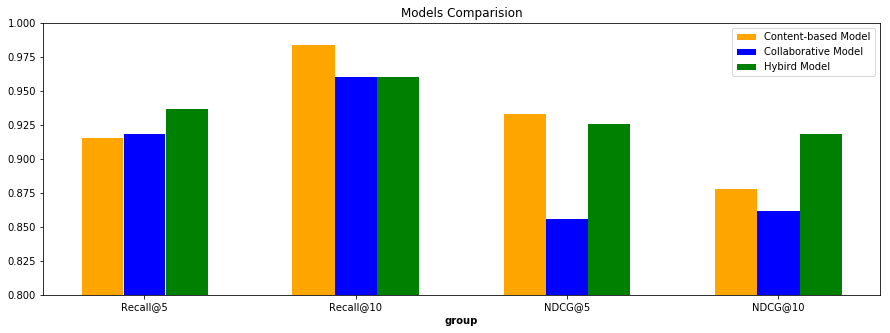

In [22]:
import matplotlib.pyplot as plt

# set width of bar
plt.figure(figsize=(15,5))
barWidth = 0.2
 
# set height of bar
bars1 = kfold_result.loc['Content-based Model'].tolist()
bars2 = kfold_result.loc['Collaborative Model'].tolist()
bars3 = kfold_result.loc['Hybird Model'].tolist()
#bars4 = kfold_result.loc[:,'ndcg@10'].tolist()
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
#r4 = [x + barWidth for x in r3]
 
# Make the plot
plt.bar(r1, bars1, color='orange', width=barWidth, edgecolor='white', label='Content-based Model')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='Collaborative Model')
plt.bar(r3, bars3, color='green', width=barWidth, edgecolor='white', label='Hybird Model')
#plt.bar(r4, bars3, color='orange', width=barWidth, edgecolor='white', label='NDCG@10')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Recall@5','Recall@10','NDCG@5','NDCG@10'])
plt.ylim(0.8,1)
plt.title('Models Comparision')
# Create legend & Show graphic
plt.legend()
plt.show()


In [23]:
new_user = GoEat.cold_start_question(999,food_df,10)


당신은 컵밥을(를) 얼마나 좋아하십니까?

0 - 먹어본 적 없음
1 - 별로 좋아하지 않음
5 - 매우 좋아함

 2

당신은 삼계탕을(를) 얼마나 좋아하십니까?

0 - 먹어본 적 없음
1 - 별로 좋아하지 않음
5 - 매우 좋아함

 5

당신은 떡갈비을(를) 얼마나 좋아하십니까?

0 - 먹어본 적 없음
1 - 별로 좋아하지 않음
5 - 매우 좋아함

 4

당신은 함박스테이크을(를) 얼마나 좋아하십니까?

0 - 먹어본 적 없음
1 - 별로 좋아하지 않음
5 - 매우 좋아함

 4

당신은 피자을(를) 얼마나 좋아하십니까?

0 - 먹어본 적 없음
1 - 별로 좋아하지 않음
5 - 매우 좋아함

 4

당신은 오므라이스을(를) 얼마나 좋아하십니까?

0 - 먹어본 적 없음
1 - 별로 좋아하지 않음
5 - 매우 좋아함

 2

당신은 곱창을(를) 얼마나 좋아하십니까?

0 - 먹어본 적 없음
1 - 별로 좋아하지 않음
5 - 매우 좋아함

 5

당신은 게장을(를) 얼마나 좋아하십니까?

0 - 먹어본 적 없음
1 - 별로 좋아하지 않음
5 - 매우 좋아함

 5

당신은 쭈꾸미을(를) 얼마나 좋아하십니까?

0 - 먹어본 적 없음
1 - 별로 좋아하지 않음
5 - 매우 좋아함

 5

당신은 김밥을(를) 얼마나 좋아하십니까?

0 - 먹어본 적 없음
1 - 별로 좋아하지 않음
5 - 매우 좋아함

 3


In [24]:
interactions_df_test = interactions_df.append(new_user,ignore_index=True)
interactions_full_df_test = interactions_df_test \
                    .groupby(['userId', 'foodId'])['eventStrength'].mean() \
                    .apply(GoEat.smooth_user_preference).reset_index()
cf_preds_df_test = GoEat.users_items_svd(interactions_full_df_test, nfactors = 20)
builder_test= GoEat.user_profiles_builder()
user_profiles_test = builder_test.build_users_profiles(interactions_full_df_test,food_df,tfidf_matrix)

In [25]:
cf_model_test = GoEat.CFRecommender(cf_preds_df_test, food_df)
cb_model_test = GoEat.CBRecommender(food_df,user_profiles_test,tfidf_matrix)
hybrid_model_test = GoEat.HybridRecommender(cb_model_test, cf_model_test, food_df)

In [26]:
cf_model_test.recommend_items(999,topn=10,items_to_ignore=new_user.foodId.tolist(),verbose=True).foodName

0      막창
1     비빔밥
2     햄버거
3     팟타이
4    샌드위치
5     불고기
6     짜장면
7     칼국수
8     떡볶이
9    생선구이
Name: foodName, dtype: object

In [27]:
cb_model_test.recommend_items(999,topn=10,items_to_ignore=new_user.foodId.tolist(),verbose=True).foodName

0      막창
1     불고기
2    오리고기
3     짜장면
4    닭도리탕
5     브리또
6     팟타이
7      짬뽕
8    뼈해장국
9     아구찜
Name: foodName, dtype: object

In [28]:
hybrid_model_test.recommend_items(999,topn=10,items_to_ignore=new_user.foodId.tolist(),verbose=True).foodName

0      막창
1     불고기
2     짜장면
3     팟타이
4     비빔밥
5    샌드위치
6    뼈해장국
7      찜닭
8     햄버거
9     아구찜
Name: foodName, dtype: object